# MNIST classification

We are going to use PYTorch and create CNN model step by step. Then we will train the model with training data and evaluate the model with test data.

In [1]:
import torch

Check available device

In [18]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## Download MNIST dataset

**What is MNIST dataset?**

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.

The MNIST database contains 60,000 training images and 10,000 testing images.
PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST, MNIST etc…) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data. They can be used to prototype and benchmark your model. In this example we are using MNIST dataset.

**Download MNIST dataset in local system**

In [19]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [20]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [21]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [22]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [23]:
print(train_data.targets.size())

torch.Size([60000])


## Visualization of MNIST dataset

**Plot one train_data**

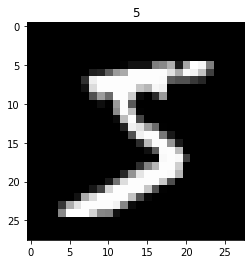

In [24]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

**Plot multiple train_data**

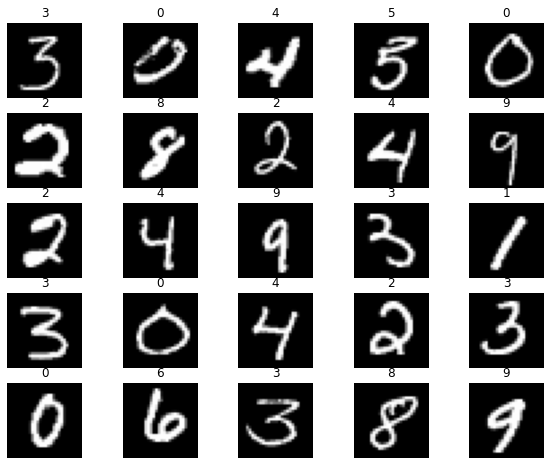

In [25]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.


In [26]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

## Define the Convolutional Neural Network model

A Convolutional Neural Network is type of neural network that is used mainly in image processing applications.
Let us create convolution neural network using `torch.nn.Module`. `torch.nn.Module` will be base class for all neural network modules. We will use 2 fully convolutional layers, Relu activation function and MaxPooling.

**Conv2d: Applies a 2D convolution over an input signal composed of several input planes.**

Parameters

- **in_channels (int)** — Number of channels in the input image
- **out_channels (int)** — Number of channels produced by the convolution
- **kernel_size (int or tuple)** — Size of the convolving kernel
- **stride (int or tuple, optional)** — Stride of the convolution. Default: 1
- **padding (int or tuple, optional)** — Zero-padding added to both sides of the input. Default: 0
- **padding_mode (string, optional)** — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’
- **dilation (int or tuple, optional)** — Spacing between kernel elements. Default: 1
- **groups (int, optional)** — Number of blocked connections from input channels to output channels. Default: 1
- **bias (bool, optional)** — If True, adds a learnable bias to the output. Default: True

In [27]:
import torch.nn as nn

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,    
            ),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        logits = self.out(x)
        return logits

**in_channels=1:** because our input is a grayscale image.

**Stride:** is the number of pixels to pass at a time when sliding the convolutional kernel.

**Padding:** to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

**kernel_size:** we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

The `forward()` pass defines the way we compute our output using the given layers and functions.

In [28]:
cnn = ConvNN().to(device)
print(cnn)

ConvNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Train the model

Define loss function

In [30]:
loss_func = nn.CrossEntropyLoss()  

Define an optimization function

In [31]:
from torch import optim

optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   

Create a function called `train()` and pass num of epochs, model and data loaders as input parameters.

`num_epochs`: Number of times our model will go through the entire training dataset

In [32]:
from tqdm.notebook import trange
from torch.autograd import Variable

def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in trange(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images, labels = images.to(device), labels.to(device)

            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = model(b_x)             
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        print('\n')

In [33]:
num_epochs = 10

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1096
Epoch [1/10], Step [200/600], Loss: 0.0454
Epoch [1/10], Step [300/600], Loss: 0.0928
Epoch [1/10], Step [400/600], Loss: 0.1035
Epoch [1/10], Step [500/600], Loss: 0.0459
Epoch [1/10], Step [600/600], Loss: 0.0398


Epoch [2/10], Step [100/600], Loss: 0.0349
Epoch [2/10], Step [200/600], Loss: 0.0462
Epoch [2/10], Step [300/600], Loss: 0.0362
Epoch [2/10], Step [400/600], Loss: 0.0604
Epoch [2/10], Step [500/600], Loss: 0.0414
Epoch [2/10], Step [600/600], Loss: 0.0426


Epoch [3/10], Step [100/600], Loss: 0.1724
Epoch [3/10], Step [200/600], Loss: 0.0725
Epoch [3/10], Step [300/600], Loss: 0.0409
Epoch [3/10], Step [400/600], Loss: 0.0605
Epoch [3/10], Step [500/600], Loss: 0.0983
Epoch [3/10], Step [600/600], Loss: 0.0139


Epoch [4/10], Step [100/600], Loss: 0.0742
Epoch [4/10], Step [200/600], Loss: 0.0623
Epoch [4/10], Step [300/600], Loss: 0.0799
Epoch [4/10], Step [400/600], Loss: 0.0564
Epoch [4/10], Step [500/600], Loss: 0.0628
Epoch

## Evaluate the model on test data

We must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.

`model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

You can call either `model.eval()` or `model.train(mode=False)` to tell that you are testing the model.

In [61]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        accuracy = 0
        for i, (images, labels) in enumerate(loaders['test']):
            images, labels = images.to(device), labels.to(device)
            
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            accuracy += (pred_y == labels).sum().item() 
        accuracy /= len(loaders['test'].dataset)
        print('Test Accuracy of the model on the 10000 test images: {:.2f} %'.format(accuracy*100.0))

In [62]:
test(cnn)

Test Accuracy of the model on the 10000 test images: 98.76 %


**Print 10 predictions from test data**

In [52]:
sample = next(iter(loaders['test']))
images, labels = sample

In [54]:
actual_number = labels[:10].numpy()
actual_number

array([5, 4, 3, 1, 4, 9, 3, 6, 9, 4])

In [55]:
test_output = cnn(images[:10].to(device))
pred_y = torch.max(test_output, 1)[1].cpu().numpy()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 4 3 1 4 9 3 6 9 4]
Actual number: [5 4 3 1 4 9 3 6 9 4]
